# 5. 오차역전파법

> 이번장에서 배운 내용
> * __오차역전파법__ 은 계산 그래프로 이해할 수 있대.
> * 계산 그래프의 노드는 국소적 계산으로 구성된다.
> * 계산 그래프의 역전파로는 각 노드의 __미분__ 을 구할 수 있다.
> * __오차역전파법__ : 신경망의 구성 요소를 계층으로 구현하여 기울기를 효율적으로 계산할 수 있다.
> * __기울기 확인__ : 수치 미분과 오차역전파법의 결과를 비교하면 오차역전파법의 구현에 잘못이 없는지 확인할 수 있다.

## 계산 그래프

* 그래프 자료구조로, 복수의 노드(node)와 에지(edge)로 표현된다.
* 계산 그래프의 특징은 각 노드에서의 계산인 '국소적 계산'을 전파함으로써 최종 결과를 얻는다는 것
* 국소적인 계산은 단순하지만, 그 결과를 전달함으로써 전체를 구성하는 복잡한 계산을 가능케 함

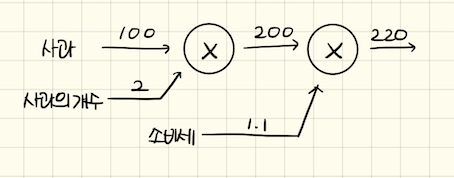

* 순전파(forward propagation)란 위의 '계산을 왼쪽에서 오른쪽으로 진행'하는 것
* 역전파(backward propagation)란 그 반대로 '계산을 오른쪽에서 왼쪽으로 진행'하는 것
* 계산 그래프의 이점은 순전파와 역전파를 활용해서 각 변수의 __미분__ 을 효율적으로 구할 수 있다는 것

## 연쇄법칙(chain rule) 

* 역전파가 '국소적 미분'을 전달하는 원리는 __연쇄법칙__ 에 따른 것
* 국소적인 미분은 상류에서 전달된 값에 곱해 앞쪽 노드로 전달하는 것

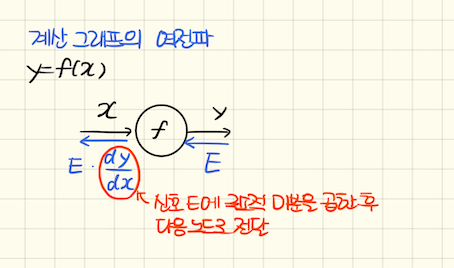

* 연쇄법칙은 합성 함수의 미분에 대한 성질이며, 다음과 같이 정의된다.
    * 합성 함수의 미분은 합성 함수를 구성하는 각 함수의 미분의 곱으로 나타낼 수 있다.

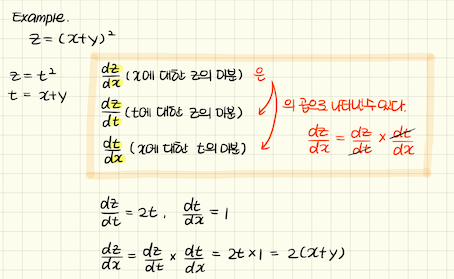

* 연쇄법칙 계산을 계산 그래프로 나타내보면 아래처럼 나타낼 수 있다.
* 맨 왼쪽 역전파를 보면 'x에 대한 z의 미분'으로 역전파가 하는 일은 연쇄법칙의 원리와 같다.

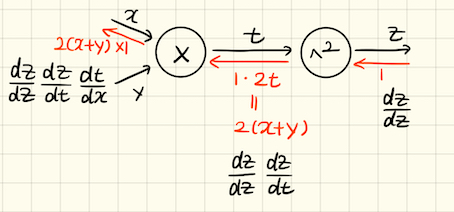

## 역전파의 구조 - 덧셈 노드, 곱셈 노드

### 덧셈 노드의 역전파

* 덧셈 노드 역전파는 입력 신호를 다음 노드로 출력한다.

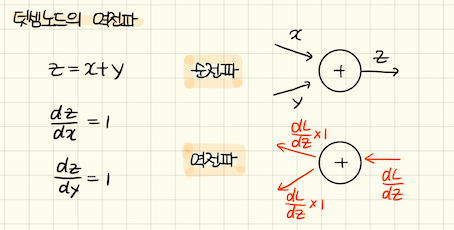

### 곱셈 노드의 역전파

* 곱셈 노드 역전파는 상류의 값에 순전파 때의 입력 신호들을 '서로 바꾼 값'을 곱해서 하류로 보낸다.
    * 그러므로 곱셈 노드 역전파는 순방향 입력 신호의 값이 필요하므로, 곱셈 노드를 구현할 때는 순전파의 입력 신호를 변수에 저장해둔다.

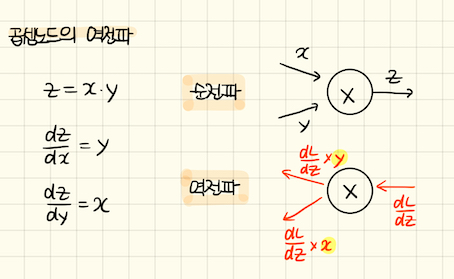

## 단순한 계층 구현하기

### 곱셈 계층

In [ ]:
class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None
        
    def forward(self, x, y):
        self.x = x
        self.y = y
        out = x * y
        return out
    
    def backward(self, dout):
        dx = dout * self.y # x와 y를 바꾼다.
        dy = dout * self.x
        return dx, dy

In [ ]:
# 순전파 예시
apple = 100
apple_num = 2
tax = 1.1

mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

apple_price = mul_apple_layer.forward(apple, apple_num)
price = mul_tax_layer.forward(apple_price, tax)

print(price) # 220

In [ ]:
# 역전파 예시
dprice = 1
dapple_price, dtax = mul_tax_layer.backward(dprice)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print(dapple, dapple_num, dtax) # 2.2 110 200

### 덧셈 계층

In [ ]:
class AddLayer:
    def __init__(self):
        pass
    
    def forward(self, x, y):
        out = x + y
        return out
    
    def backward(self, dout):
        dx = dout * 1
        dy = dout * 1
        return dx, dy

In [ ]:
# 사과 2개와 귤 3개를 사는 상황 구현
# 사과 가격: 100(1개), 귤 가격: 150(1개)
# 소비세: 10%

apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

# 순전파
apple_price = mul_apple_layer.forward(apple, apple_num)
orange_price = mul_orange_layer.forward(orange, orange_num)
all_price = add_apple_orange_layer.forward(apple_price, orange_price)
price = mul_tax_layer.forward(all_price, tax)

# 역전파
dprice = 1
dall_price, dtax = mul_tax_layer.backward(dprice)
dapple_price, dorange_price = add_apple_orange_layer.backward(dall_price)
dorange, dorange_num = mul_orange_layer.backward(dorange_price)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print(price) # 715
print(dapple_num, dapple, dorange, dorange_num, dtax) # 110 2.2 3.3 165.0 650

## 활성화 함수 계층 구현하기 - ReLU, Sigmoid

### ReLU

* 순전파 때의 입력인 x가 0보다 크면 역전파는 상류의 값을 그대로 하류로 흘린다.
* 순전파 때 x가 0 이하면 역전파 때는 하류로 신호를 보내지 않는다.

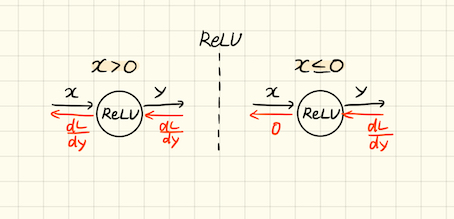

* Relu 클래스는 mask라는 인스턴스 변수를 가진다.
* 역전파 때는 순전파 때 만들어둔 mask를 써서 mask의 원소가 True인 곳에는 상류에서 전파된 dout을 0으로 설정한다.

In [ ]:
import numpy as np

x = np.array([[1.0, -0.5], [-2.0, 3.0]])
print(x)
mask = (x <= 0)
print(mask)

In [ ]:
class Relu:
    def __init__(self):
        self.mask = None
    
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        return out
    
    def backward(slef, dout):
        dout[self.mask] = 0
        dx = dout
        return dx

### Sigmoid

* Sigmoid 계층의 역전파는 순전파의 출력(y)만으로 계산할 수 있다.

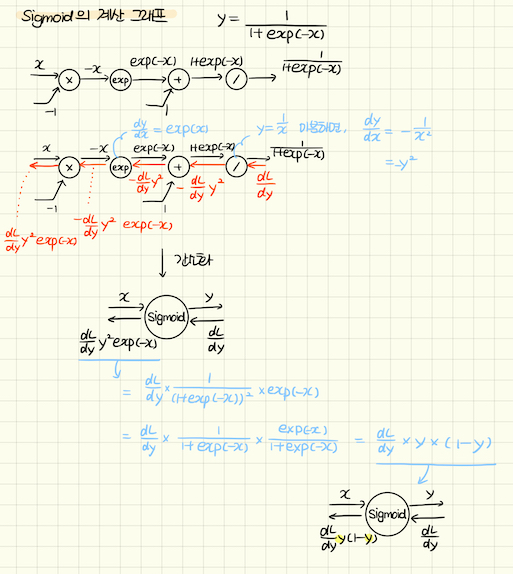

In [ ]:
class Sigmoid:
    def __init__(self):
        self.out = None
        
    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out # 순전파의 출력을 인스턴스 변수 out에 보관, 역전파 계산 때 사용
    
    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx

## Affine/Softmax 계층 구현하기

### Affine 계층

* 행렬의 곱 계산은 대응하는 차원의 원소 수를 일치시키는게 핵심
* 신경망의 순전파 때 수행하는 행렬의 곱은 기하학에서는 어파인 변환(affine transformation)이라고 함
* 어파인 변환을 수행하는 처리를 'Affine 계층'이라는 이름으로 구현
* 행렬의 곱('dot' 노드)의 역전파는 행렬의 대응하는 차원의 원소 수가 일치하도록 곱을 조립하여 구할 수 있다.

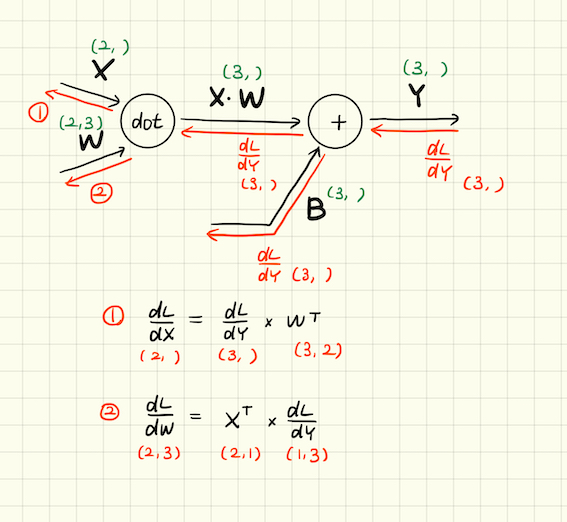

### 배치용 Affine 계층

* 데이터 N개를 묶어 순전파하는 경우를 고려한 배치용 Affine 계층
* 순전파의 편향 덧셈은 각각의 데이터(1번째 데이터, 2번째 데이터, ...)에 더해진다.
    * 역전파 때는 각 데이터의 역전파 값이 편향의 원소에 모여야 한다.
    * np.sum(axis=0)을 이용

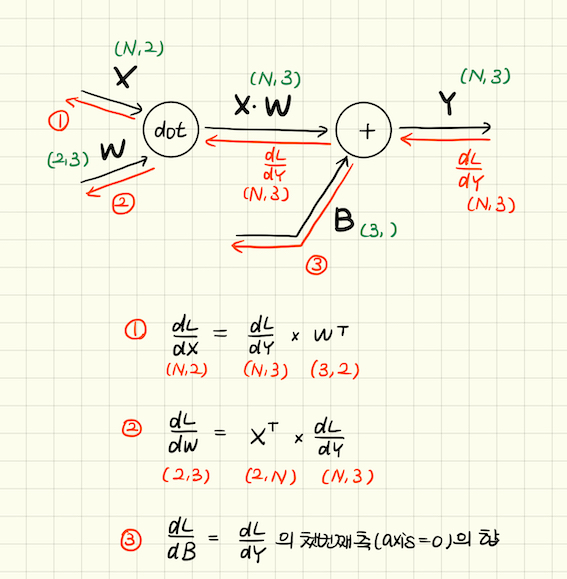

### Softmax-with-Loss 계층

* 손실함수인 교차 엔트로피 오차도 포함한 소프트맥스 계층 구현
* softmax 계층은 입력 (a1, a2, a3)를 정규화하여 (y1, y2, y3)를 출력한다.
* cross-entropy-error 계층은 softmax의 출력 (y1, y2, y3)와 정답 레이블 (t1, t2, t3)를 받고, 이 데이터들로부터 손실 L을 출력
* softmax 계층의 역전파는 (y1-t1, y2-t2, y3-t3)라는 말끔한 결과를 냄
    * softmax 함수의 loss function으로 'cross entropy error'를 사용하면 그렇게 되도록 설계된 것
    * 마찬가지로, 항등함수의 loss function으로 'sum of squared error(SSE);오차제곱합'을 사용
* 신경망 학습의 목적은 신경망 출력(softmax의 출력)이 정답 레이블과 가까워지도록 가중치 매개변수의 값을 조정하는 것
    * 신경망의 출력과 정답 레이블의 오차를 효율적으로 앞 계층에 전달해야 한다.
    * (y1-t1, y2-t2, y3-t3)라는 결과는 softmax 계층의 출력과 정답 레이블의 차이
    * 신경망의 현재 출력과 정답 레이블의 오차를 있는 그대로 드러낸다.
* 역전파 때는 전파하는 값을 배치의 수(batch_size)로 나눠서 데이터 1개 당 오차를 앞 계층으로 전파하는 점 주의

In [ ]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 손실
        self.y = None # softmax의 출력
        self.t = None # 정답 레이블(one hot vector)
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x) # 3. 신경망 챕터 참고
        self.loss = cross_entropy_error(self.y, self.t) # 4. 신경망학습 챕터 참고
        return self.loss
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size
        return dx

## 오차역전파법 구현하기

### 오차역전파법

In [ ]:
import numpy as np
from common.functions import *
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict

class TwoLayerNet:
    
    def __init__(self, input_size, hidden_size, output_size,
                 weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = weight_init_std * np.random.randn(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
        # 계층 생성
        self.layers = OrderdDict() # 순서가 있는 딕셔너리
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    
    # x: 입력 데이터, t: 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
        
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1: # one hot encoding일 때
            t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    
    def numerical_gradient(self, x, t): # 미분 계산
        loss_W = lambda W: self.loss(x, t)
        
        grads = {} # params 변수에 대응하는 각 매개변수의 기울기가 저장
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])    
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
    def gradient(self, x, t):
        # 순전파
        self.loss(x, t)
        
        # 역전파
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse() # 계층 순서를 거꾸로
        for layer in layers:
            dout = layer.backward(dout) # 거슬러 올라가며 역전파 계산
        
        # 결과저장
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Afifne2'].dW
        grads['b2'] = self.layers['Affine2'].db
        
        return grads

### 기울기 검증

* 수치 미분의 결과와 오차역전파법의 결과를 비교하여 오차역전파법을 제대로 구현했는지 검증
* 이를 기울기 확인(gradient check)이라고 함

In [ ]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, out_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

# 각 가중치의 차이의 절댓값을 구한 후, 그 절댓값들의 평균을 낸다.
for key in grad_numerical.keys():
    diff = np.average(np.abs(grad_backprop[key] - grad_numerical[key]))
    print(key + ":" + str(diff))

### 오차역전파법을 사용한 학습 구현

In [ ]:
import numpy as np
from master.dataset.mnist import load_mnist
from master.two_layer_net import TwoLayerNet

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_encoding=True)
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_poch = max(train_size/batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 오차역전파법으로 기울기를 구한다.
    grad = network.gradient(x_batch, t_batch)
    
    # 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        nerwork.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_poch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(train_acc, test_acc)